In [1]:
#Loading needed libraries
import os
import argparse
import json
import pickle
import pandas as pd
import numpy as np
import math
import tensorflow as tf
import random

import torch

from torch.utils.data import DataLoader, random_split
from torch.optim import SGD, Adam

from data_loaders.assist2009 import ASSIST2009
from data_loaders.assist2015 import ASSIST2015
from data_loaders.algebra2005 import Algebra2005
from data_loaders.statics2011 import Statics2011
from models.dkt import DKT
from models.dkt_plus import DKTPlus
from models.dkvmn import DKVMN
from models.sakt import SAKT
from models.gkt import PAM, MHA
from models.utils import collate_fn
from api import *

A dataset with the format needed for training a model can be loaded using the function with same name as the dataset. Notice that cognitive tutor does not have a loader. We might need to implement our own one or opt for any of the other datasets (KDDCup Algebra 2005-2006 seems promising)

In [2]:
dataset = ASSIST2009(100)
print(dataset[0:2])

([array([67, 18, 67, 18, 67, 18, 18, 67, 67, 18, 18, 67, 32, 35, 18, 32, 18,
       74, 32, 18, 32, 18, 74, 32, 18, 32, 35, 18, 49, 77, 77, 49, 77, 49,
       49, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]), array([48, 99, 48, 99, 48, 99, 99, 48, 49, 99, 99, 49, 49, 99, 54, 54, 54,
       54, 54, 54, 54, 54, 54, 54, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1])], [array([ 0,  0,  1,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  1,  1,  0,  0

In [3]:
loader = DataLoader(
        dataset, batch_size=512, shuffle=False,
        collate_fn=collate_fn
    )
for i,l in enumerate(loader) :
    if i == 0:
        print(l)

(tensor([[67., 18., 67.,  ..., -0., -0., -0.],
        [48., 99., 48.,  ..., -0., -0., -0.],
        [31., 31., 31.,  ..., -0., -0., -0.],
        ...,
        [ 6.,  6.,  6.,  ..., -0., -0., -0.],
        [60., 62., 62.,  ..., -0., -0., -0.],
        [ 0., -0., -0.,  ..., -0., -0., -0.]]), tensor([[0., 0., 1.,  ..., -0., -0., -0.],
        [0., 0., 1.,  ..., -0., -0., -0.],
        [0., 1., 1.,  ..., -0., -0., -0.],
        ...,
        [0., 1., 1.,  ..., -0., -0., -0.],
        [1., 1., 1.,  ..., -0., -0., -0.],
        [0., -0., -0.,  ..., -0., -0., -0.]]), tensor([[18., 67., 18.,  ..., -0., -0., -0.],
        [99., 48., 99.,  ..., -0., -0., -0.],
        [31., 31., 31.,  ..., -0., -0., -0.],
        ...,
        [ 6.,  6.,  6.,  ..., -0., -0., -0.],
        [62., 62., 60.,  ..., -0., -0., -0.],
        [-0., -0., -0.,  ..., -0., -0., -0.]]), tensor([[0., 1., 1.,  ..., -0., -0., -0.],
        [0., 1., 1.,  ..., -0., -0., -0.],
        [1., 1., 1.,  ..., -0., -0., -0.],
        ...,


It is extremely important to understand the data. Note that we are inputing a tuple <sequence of skills_id, sequence of correct/incorrect>. We are never introducing any other type of information, such as the id of the exercise or the response time. Excluding the id of the exercise might be inconvenient for our proposal, as we can no longer explain a prediction in terms of exercises done in the past. However, we can still try to identify sequences of skill_ids in our data.

In [4]:
for i in dataset :
    print(i)

(array([67, 18, 67, 18, 67, 18, 18, 67, 67, 18, 18, 67, 32, 35, 18, 32, 18,
       74, 32, 18, 32, 18, 74, 32, 18, 32, 35, 18, 49, 77, 77, 49, 77, 49,
       49, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]), array([ 0,  0,  1,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  1,  1,  0,  0,  0,  1,  1,  0,  0,  0,  0,  1,  1,  0,  1,  0,
        0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
      dtype=int64))
(array([48, 99, 48, 99, 48, 99, 99, 48, 49, 99, 99, 49, 49, 99, 54, 54, 54,
       5

       0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1], dtype=int64))
(array([62, 54, 58, 58, 58, 58, 58, 58, 58, 93, 98, 84, 54, 54, 54, 54, 84,
       84,  1,  1,  1,  1,  1,  1,  1,  1,  4,  2, 55, 62,  3, 94, 94, 94,
       94, 94, 61, 60, 61,  3,  3,  3,  3,  3,  2, 54, 54, 54, 54, 54,  3,
        3,  3,  3,  3,  3,  3, 99, 48, 99, 48, 48, 99, 54, 54, 54, 54, 54,
       74, 74, 74, 74, 67, 52, 54, 54, 54, 54, 54, 34, 94, 33, 94, 33, 94,
       33, 94, 33, 33, 94, 33, 94, 94, 33, 94, 33, 33, 94,  2,  2,  2]), array([1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0,
       1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1,
       0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1], dtype=int64))
(array([  2,   2,   3,   3,   3,   3,   3, 102, 102, 102, 102, 102, 102,
        99,  77,  77,  99,  61,  73,  73,  73,  99,  73,  99,  3

       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int64))
(array([62, 62, 62, 59, 59, 59, 59, 31, 31, 31, 31, 31, 31, 31, 31, 31, 58,
       58, 58, 58, 58, 59, 59, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
       23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
       23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 39, 99, 99, 73, 99, 39,
       39, 99, 73, 99, 99, 39, 73, 99, 99, 39, 39, 99, 99, 73, 39, 99, 74,
       74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74]), array([1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1,
       0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0], dtype=int64))
(array([ 74,  74,  74,  74,  74,  74,  74,  74,  74,  74,  74,  74,  74,
        67,  67,  67,  67,  67,  67,  67,  67,  67,  67,  67,  6

       1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int64))
(array([41, 74, 74, 74, 74, 74, 35, 67, 18, 67, 35, 35, 35, 35, 35, 35, 35,
       23, 23, 23, 23, 23,  0,  0,  0,  0,  0,  0,  0,  0, 41, 48, 99, 48,
       99, 49, 99, 99, 49, 99, 49, 49, 99, 49, 99, 99, 51, 99, 51, 86, 77,
       99, 77, 99, 77, 99, 77, 99, 95, 49, 95, 48, 49, 49, 48, 49, 49, 49,
       49, 77, 77, 77, 48, 99,  1, 96, 65, 96, 65, 65, 96, 65, 96, 65, 96,
       86, 86, 86, 86, 95, 48, 95, 77, 95, 49, 95, 77, 95, 48, 15, 49]), array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1,
       0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0], dtype=int64))
(array([ 77,  15,  15,  77,  49,  15,  15,  77,  15,  49,  73,  73,  73,
        73,  73,  72,  72,  72,  72,  72,  99,  39,  39,  99,  7

       1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1], dtype=int64))
(array([ 4,  4,  4,  4, 52, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74,  2,
        2,  2,  2, 41, 41, 41, 41, 41, 77, 15, 49, 15, 49, 15, 15, 49, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]), array([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  0,  1,  0,  1,  0,  1,  0,  0,
        0,  0,  0,  0,  1,  0,  1,  1,  0,  0,  1,  1,  1,  1,  1,  1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
      dtype=int64))
(array([ 1,  1,  1,  1,

      dtype=int64))
(array([56, 56, 56, 56, 25, 25, 25, 25, 75, 75, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]), array([ 0,  1,  1,  1,  1,  0,  1,  1,  1,  0, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
      dtype=int64))
(array([43, 44, 44, 43, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 

(array([ 94,  94,  94,  27,  27,  27,  27,  27,  58,  71,  87,  87,  87,
        87,  87,  94,  94,  33,  94,  33,  94,  33,  94,  33,  33,  94,
        94,  94,  94,  94,  94,  94,  94,  94,  94,  94,  94,  94,  61,
        60,  60,  60,  60,  60,  60,  63,  61,  94,   3,   2,  63,  61,
        94,  63,  61,  94,  94,  63,  61,  63,  94,  61, 102, 102,  35,
        67,  67,  18,  67,  74,  74,  74,  74,  74,  74,  74,  74,  74,
        74,  16, 101,   4, 101, 101, 101,   4, 101,  16,  29,   4, 101,
       101,  29,  16,  29,  16,  29,  16,  29,  16,  77]), array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1], dtype=int64))
(array([ 49,  51,  99,  51,  99,   1,  99,  99,  49,  99,  49,  86,  73,
        73

      dtype=int64))
(array([77, 15, 15, 49, 49, 15, 15, 49, 49, 15, 99, 48, 48, 99, 48, 99, 99,
       48, 49, 99, 49, 49, 99, 49, 99, 99, 49, 51, 99, 51, 99, 51, 99, 99,
       51, 99, 77, 77, 99, 77, 95, 77, 95, 48, 95, 95, 51, 95, 49, 95, 49,
       59, 59, 94, 94, 94, 94, 94, 74, 74, 74, 74, 74, 87, 87, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]), array([ 0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  0,  0,  1,  1,  1,  1,  1,
        1,  1,  0,  0,  1,  1,  1,  1,  1,  1,  0,  0,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  0,  0,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  0,  0, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
      dtype=int64))
(array([99, 48, 48, 99, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



If we want to get the dataset in a pandas dataframe, we can easily get it with the read_csv function over the .csv file

In [5]:
pd.read_csv("./datasets/ASSIST2009/skill_builder_data.csv",encoding_errors = "ignore")

C:\Users\Enri\AppData\Local\Temp\ipykernel_13432\1613730494.py:1: DtypeWarning: Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.
  pd.read_csv("./datasets/ASSIST2009/skill_builder_data.csv",encoding_errors = "ignore")


order_id  assignment_id  user_id  assistment_id  problem_id  original  \
0       33022537         277618    64525          33139       51424         1   
1       33022709         277618    64525          33150       51435         1   
2       35450204         220674    70363          33159       51444         1   
3       35450295         220674    70363          33110       51395         1   
4       35450311         220674    70363          33196       51481         1   
...          ...            ...      ...            ...         ...       ...   
525529  38214014         291495    96299          57830      108976         0   
525530  38214016         291495    96299          57843      109015         0   
525531  38214195         291503    96299          34577       54060         0   
525532  38214196         291503    96299          34577       54061         0   
525533  38214198         291503    96299          34577       54062         0   

        correct  attempt_count  ms_first_response tutor_mode  ... hint_count  \
0             1              1              32454      tutor  ...          0   
1             1              1               4922      tutor  ...          0   
2             0              2              25390      tutor  ...          0   
3             1              1               4859      tutor  ...          0   
4             0             14              19813      tutor  ...          3   
...         ...            ...                ...        ...  ...        ...   
525529        1              1              38234      tutor  ...          0   
525530        1              1               6500      tutor  ...          0   
525531        1              1              18344      tutor  ...          0   
525532        1              1              12922      tutor  ...          0   
525533        0              9              36047      tutor  ...          1   

        hint_total  overlap_time  template_id answer_id  answer_text  \
0                3         32454        30799       NaN           26   
1                3          4922        30799       NaN           55   
2                3         42000        30799       NaN           88   
3                3          4859        30059       NaN           41   
4                4        124564        30060       NaN           65   
...            ...           ...          ...       ...          ...   
525529           2         38234        55692  200260.0          NaN   
525530           0          6500        55693  200299.0          NaN   
525531           3         18344        30677       NaN          0.8   
525532           2         12922        30677       NaN           -6   
525533           3        163422        30677       NaN         -6.8   

        first_action bottom_hint  opportunity  opportunity_original  
0                  0         NaN            1                   1.0  
1                  0         NaN            2                   2.0  
2                  0         NaN            1                   1.0  
3                  0         NaN            2                   2.0  
4                  0         0.0            3                   3.0  
...              ...         ...          ...                   ...  
525529             0         NaN           54                   NaN  
525530             0         NaN           55                   NaN  
525531             0         NaN           56                   NaN  
525532             0         NaN           57                   NaN  
525533             0         0.0           58                   NaN  

[525534 rows x 30 columns]

The following function takes as input the dataset name and model type, trains a model and returns it as an output. It is basically an adaptation of the function "main.py" of the library. Advanced options can be specified in the file "config.json" and the implementation can be found in api.py. 

Here, we train a DKT model with the ASSIST2009 dataset 

In [6]:
model = get_model("dkt","ASSIST2009")

Epoch: 1,   Loss train: 0.6279892325401306,   AUC: 0.753708848213273,   Loss test: 0.5704429745674133
Epoch: 2,   Loss train: 0.6012957096099854,   AUC: 0.7809748274973293,   Loss test: 0.5548511743545532
Epoch: 3,   Loss train: 0.5997164845466614,   AUC: 0.7933289314685521,   Loss test: 0.5402830243110657


Get a prediction over an input (a sequence of pairs $<question,answer>$)

In [7]:
model.eval()
input_1= torch.from_numpy(dataset[5][0])
answer_1 = torch.from_numpy(dataset[5][1])
output_1 = model(input_1,answer_1)

The model returns a matrix $[seq\_len,n\_skills]$, where the position $[i,j]$ the level of knowledge of the j-th knowledge concept after the i-th interaction. We can get the increment in skill mastery throughout the learning process as follows:

In [8]:
output_1[-1]-output_1[0]

tensor([ 0.0268,  0.0230, -0.0280,  0.0618,  0.0368, -0.0467,  0.0108,  0.0104,
         0.0477, -0.0969,  0.0170,  0.0687,  0.1107,  0.0063,  0.0882, -0.1455,
        -0.0026, -0.0584,  0.0054, -0.0145, -0.0361, -0.0182,  0.0525,  0.0362,
        -0.0082, -0.0081, -0.0245,  0.0297,  0.0984, -0.1168,  0.0811,  0.0179,
         0.0657, -0.0836, -0.0234, -0.0002, -0.0188,  0.0007,  0.0832,  0.0345,
         0.0815,  0.0383,  0.0063,  0.0007, -0.0857, -0.0409, -0.0453,  0.0007,
        -0.0309,  0.0270,  0.0421,  0.0755,  0.0419, -0.0660,  0.1312,  0.0338,
        -0.0674,  0.0604,  0.0341, -0.0077, -0.0083, -0.0853, -0.0206, -0.1482,
         0.0178,  0.0748,  0.0235,  0.0571,  0.0223, -0.0449, -0.0396,  0.0294,
         0.0497,  0.0228, -0.0020, -0.0313, -0.0351,  0.0544,  0.0529,  0.0326,
         0.0827,  0.0358, -0.0008,  0.0275,  0.0942, -0.0782,  0.0561, -0.0921,
        -0.0508, -0.0053,  0.0820,  0.0940,  0.0888, -0.0731, -0.1716, -0.1281,
         0.0208,  0.0005, -0.0568, -0.14

We can see that the probabilities of skill mastery output by the system orbit around 0.5 in order to maximize the AUC. However, this could be a problem if we try to use the model to generate our own sequences

In [9]:
sum = 0
print("First 5 interactions")
print("Question \t Answer \t Predicted answer \t Absolute error")
for i in range(1,len(output_1)) :
    if (i<20) :
        print(int(input_1[i]),"\t \t",int(answer_1[i]),"\t \t",float(output_1[i-1,input_1[i]]),"\t",abs(float(output_1[i-1,input_1[i]])-float(answer_1[i])))
    sum = sum + abs(float(output_1[i-1,input_1[i]])-float(answer_1[i]))
print("MAE",(sum/(len(output_1)-1)))

First 5 interactions
Question 	 Answer 	 Predicted answer 	 Absolute error
9 	 	 0 	 	 0.5879501104354858 	 0.5879501104354858
1 	 	 1 	 	 0.4557168483734131 	 0.5442831516265869
0 	 	 1 	 	 0.7100770473480225 	 0.28992295265197754
1 	 	 1 	 	 0.7853348851203918 	 0.21466511487960815
0 	 	 1 	 	 0.7963498830795288 	 0.2036501169204712
3 	 	 0 	 	 0.6389057040214539 	 0.6389057040214539
3 	 	 1 	 	 0.5488171577453613 	 0.45118284225463867
3 	 	 1 	 	 0.6365440487861633 	 0.36345595121383667
3 	 	 1 	 	 0.6578012704849243 	 0.3421987295150757
4 	 	 1 	 	 0.4976319670677185 	 0.5023680329322815
2 	 	 1 	 	 0.6243317127227783 	 0.3756682872772217
2 	 	 1 	 	 0.6802001595497131 	 0.31979984045028687
1 	 	 1 	 	 0.7110510468482971 	 0.2889489531517029
1 	 	 1 	 	 0.7428327202796936 	 0.2571672797203064
1 	 	 1 	 	 0.7355954051017761 	 0.2644045948982239
1 	 	 1 	 	 0.7331072688102722 	 0.2668927311897278
1 	 	 1 	 	 0.7318826913833618 	 0.2681173086166382
62 	 	 1 	 	 0.6240883469581604 	 0.

The function generate is able to generate synthetic data. It requires as input the model, a sequence of question, a sequence of answer and the interaction from which we want to start to generate the data and outputs a synthetic squence that starts from ini and its likelihood. Let's generate 200 sequences starting from the second interaction

In [10]:
res = []
for i in range(0,200) :
    res.append(generate_seq(model,[46,46,46,46],[0,1,1,1],ini=2, method = "ran"))
res[0:5]

[([0, 1, 1, 1], 0.46379262817724864),
 ([0, 1, 1, 1], 0.46379262817724864),
 ([0, 1, 0, 0], 0.14853804025692696),
 ([0, 1, 1, 1], 0.46379262817724864),
 ([0, 1, 1, 1], 0.46379262817724864)]

We create an alternative input by deleting the 95 interaction from the sequence. The altered input sequence of questions will be renamed as "input_alt"

In [11]:
print(input_1[96],answer_1[96])
input_alt = torch.cat([input_1[:96], input_1[97:]])

tensor(61, dtype=torch.int32) tensor(0)


We generate the set of answers for our new input starting from the 95-th interaction (the one we deleted). Then, we input the sequence of altered questions and the synthetically computed answer to the model and get the skill mastery (variable "output"). We do this 500 and compute the weighted average of the difference of skill mastery between the original input and for each of the 500 generated sequences (where the weights are the likelihood of the sequences).

In [12]:
res = []
l_list = []
for i in range(0,500):
    answer_alt,likelihood = generate_seq(model, input_alt, answer_1, ini = 96, method = "ran")
    output_alt= model(input_alt, answer_alt)
    res.append(likelihood * ((output_1[-1]-output_alt[-1])).detach().numpy())
    l_list.append(likelihood)
print(np.sum(res,axis=0)/np.sum(l_list))
print(np.mean(np.sum(res,axis=0)/np.sum(l_list)))

D:\Enrique\Universidad\Repositories\KT-XAI\api.py:153: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  output = model(torch.tensor(input_seq[0:i+1]), torch.tensor(rec_answer_seq[0:i+1]))


[-0.04452107  0.0412277  -0.06554212 -0.00978046 -0.01355596 -0.02268479
  0.02531171 -0.04979596 -0.0143923  -0.06547934  0.04285127 -0.0362918
 -0.03012285 -0.00668171  0.00394809 -0.14611356 -0.01402621 -0.08333015
 -0.06501975 -0.03324678 -0.04118656  0.02923751 -0.06764919 -0.02122389
 -0.0081368  -0.04235964 -0.0331854   0.00297392  0.00454779 -0.0074273
  0.02188573 -0.01231008  0.03956606 -0.09033352 -0.09137043 -0.02249612
  0.01578358 -0.0029138   0.06214249  0.01206734 -0.0081212   0.01318946
 -0.05309726  0.06992701 -0.08508851  0.02145026 -0.01559288 -0.06654322
  0.02237258  0.04384267 -0.02337869  0.02022571 -0.00455014 -0.11400549
  0.0052591   0.00124015 -0.17539857  0.0320236  -0.07189471 -0.02034625
 -0.09274345 -0.23235103 -0.07770336 -0.2392295  -0.06817882 -0.01161428
  0.02800376  0.03880629  0.01693731 -0.06765065 -0.00396196  0.05750524
  0.02257542 -0.03531237 -0.03372249 -0.01547961  0.05324366  0.05149041
  0.06876554  0.01023511  0.02759266  0.01533849  0.0

### Clustering of features/ instants
The following cells focus on different methods to cluster both time instants and features, to extract some conclusion.


In [13]:
max(np.cov(output_1.detach().numpy())[60])

0.005230241234592687

There are many ways we can cluster the interactions. First, we can distinguish between clustering knowledge concepts and directly clustering the interactions. We are going to focus first in interaction clustering. As expected, the result show subsequences in the learning process with similar knowledge level

In [14]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3).fit(output_1.detach().numpy())
print(kmeans.labels_)
#kmeans.cluster_centers_
print(answer_1)

[2 2 2 2 1 2 2 2 2 2 1 1 1 1 1 1 1 1 0 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1
 1 1 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 2 2 2 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 2 2 2 2 2 2]
tensor([1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
        0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1,
        0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0,
        1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
        0, 1, 1, 0, 0])


In [15]:
def find_bkps(cluster_list) :
    bkps_list = []
    previous = -1
    for i,current in enumerate(cluster_list) : 
        if current!=previous :
            bkps_list.append(i)
        previous = current
    return bkps_list

In [16]:
cluster_bkps = find_bkps(kmeans.labels_)

We can also cluster the features attending to skill at every time point. We cluster the features that have a similar value over time. However, does this make sense? It doesn't seem very informative

In [17]:
from sklearn.cluster import FeatureAgglomeration
agglo = FeatureAgglomeration(n_clusters=3)
agglo.fit(output_1.detach().numpy())
print(agglo.labels_[1:-1])
X_reduced = agglo.transform(output_1.detach().numpy())
print(X_reduced.shape)
input_reduced = [agglo.labels_[i] for i in input_1]
print(input_reduced)

[0 0 0 0 2 2 0 0 0 2 0 0 0 0 0 1 1 1 0 0 2 0 0 1 0 0 1 0 1 0 1 1 1 0 1 1 1
 1 1 0 0 1 1 0 2 1 1 1 1 0 0 0 1 0 0 0 1 0 1 1 0 0 0 0 1 2 1 1 0 1 0 1 0 1
 1 2 0 2 1 0 1 1 2 0 1 0 1 1 1 1 2 2 1 0 1 0 2 1 0 1 1 1 0 1 0 1 1 1]
(101, 3)
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


Cluster the time instant according to the change compared with the previous instant. Each cluster then represents the level of impact in the skill mastery acquisition. It is probably informative, but not the best way to cluster time instants.

In [18]:
differential = np.diff(output_1.detach().numpy(), axis=0)
kmeans = KMeans(n_clusters=5).fit(differential)
print(kmeans.labels_)
#kmeans.cluster_centers_
print(answer_1)
#print(kmeans.cluster_centers_)


[1 3 0 2 0 1 1 1 1 2 2 1 2 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 3 2 1 1 2 3 2 1
 3 0 1 4 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 2 2 1 1 2 2 2 1 1 1 2 1 2 2 1
 1 2 1 1 0 1 2 1 1 1 1 1 1 1 2 2 1 2 2 0 1 2 1 2 1 2]
tensor([1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
        0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1,
        0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0,
        1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
        0, 1, 1, 0, 0])


Cluster feature according to the skill mastery level differential. This makes more sense (IMO) than the previous clustering, as now we cluster features according to correlation in their changes over time

In [19]:
agglo = FeatureAgglomeration(n_clusters=40)
agglo.fit(differential)
print(agglo.labels_)
X_reduced = agglo.transform(differential)
print(X_reduced.shape)
input_reduced = [agglo.labels_[i] for i in input_1]
print(input_reduced)

[ 4  6 17 32 29  1  0 33 32  8  9 15 15 12 15 21 17 20 38 12 11 14  6 13
 28 10  8 22 10  9 12 13  2  7 33  2  1 10  0  8  5 13 34 31 17  1 24 20
 25  3 13 25 12 27 32 11  4 16 13 13 10 35 10  7 33 22  1 39 19 15 31 26
 37  1  2 10  9  3  8 16  6 16  1 14 12  0  3 12  0 34 23 19 19  2 18 21
 36 16 24 21 20  5 12 30  0 15  1 19  0 11]
(100, 40)
[8, 8, 6, 4, 6, 4, 32, 32, 32, 32, 29, 17, 17, 6, 6, 6, 6, 6, 10, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 5, 12, 27, 5, 5, 27, 5, 5, 27, 5, 39, 39, 39, 39, 39, 11, 11, 11, 11, 10, 10, 10, 10, 32, 32, 32, 32, 32, 33, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 32, 32, 32, 24, 24, 24, 24, 24, 24, 24, 24, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 35, 35, 18, 35, 7, 18, 7, 35, 35, 18, 7, 35]


In [20]:
total_variance = np.sum(np.std(differential,axis=1))
print(total_variance)
total_variance = np.std(np.sum(differential,axis=1))
print(total_variance)

2.9420657
0.9174012


In [21]:
def feature_clustering_ev(dataset, labels) :
    total_variance = np.sum(np.std(dataset,axis=1))
    n_clusters = max(labels)+1
    variance_explained = 0
    for i in range(0,n_clusters) :
        cluster_members = dataset[:,labels == i]
        variance_explained = variance_explained + np.sum(np.std(cluster_members,axis=1))
        #variance_explained = variance_explained + np.sum(np.std(dataset[:,labels == i],axis=1))
    variance_explained = variance_explained/n_clusters
    return (1-(variance_explained/total_variance))*100

In [22]:
feature_clustering_ev(differential, agglo.labels_)

64.80410262855881

In [23]:
x_label=list(range(1,output_1.shape[1]+1))
y_label = []
for i in range(1,output_1.shape[1]+1) :
    agglo_temp = FeatureAgglomeration(n_clusters=i)
    agglo_temp.fit(differential)
    y_label = np.append(y_label,feature_clustering_ev(differential, agglo_temp.labels_))

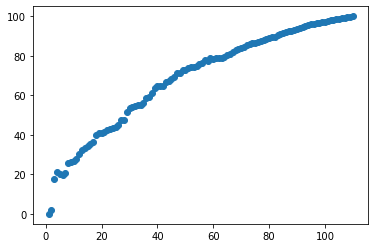

0.6833310664464692


In [24]:
import matplotlib.pyplot as plt
plt.scatter(x_label,y_label)
plt.show()
print(np.trapz(y_label)/(110*100))

In [25]:
def reduce_input(input_1, labels) :
    return [agglo.labels_[i] for i in input_1]

def reduce_output(output_1, n_clusters = None, labels = None) :
    if labels is None :
        differential = np.diff(output_1.detach().numpy(), axis=0)
        agglo = FeatureAgglomeration(n_clusters=n_clusters)
        agglo.fit(differential)
        labels = agglo.labels_
    return np.array([[np.mean(i[labels == j]) for j in range(0,n_clusters)] for i in output_1.detach().numpy()])

In [26]:
output_red = reduce_output(output_1,20)

In [27]:
kmeans = KMeans(n_clusters=3).fit(output_red)
print(kmeans.labels_)
#kmeans.cluster_centers_
print(answer_1)
cluster_bkps = find_bkps(kmeans.labels_)

[2 2 2 2 0 2 2 2 2 2 1 1 1 0 0 0 0 0 0 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1
 1 1 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0
 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2]
tensor([1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
        0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1,
        0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0,
        1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
        0, 1, 1, 0, 0])


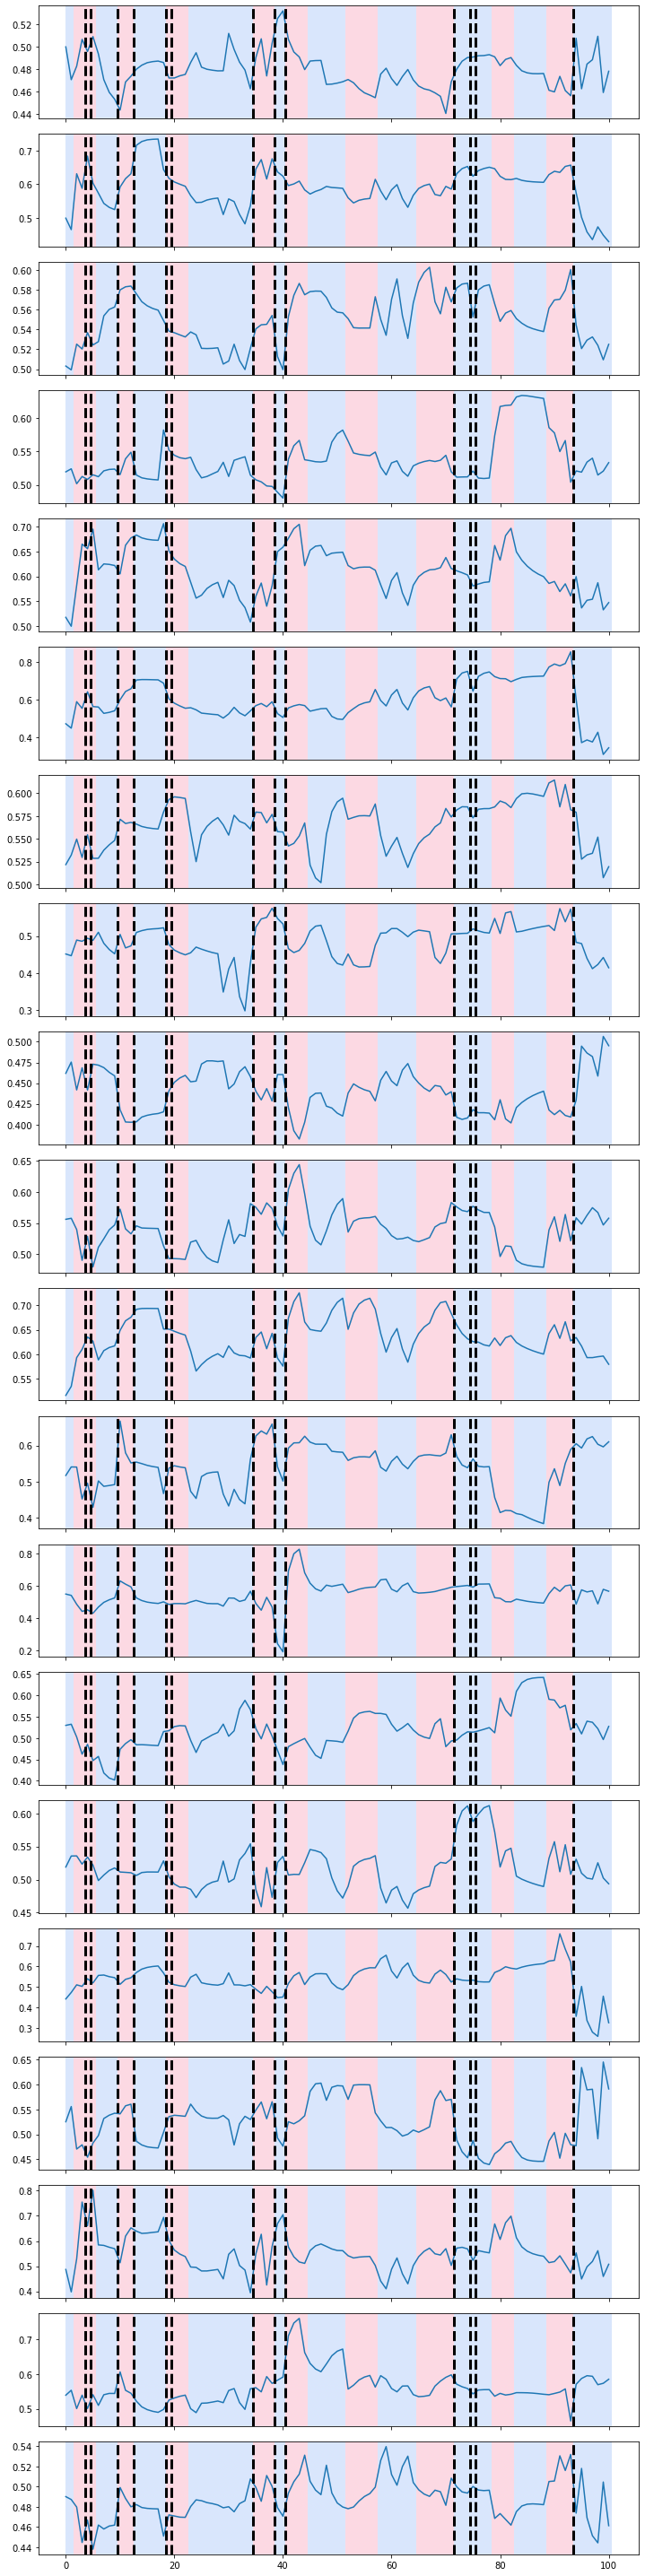

In [28]:
import ruptures as rpt

# generate signal
n_samples, dim, sigma = 1000, 3, 4
n_bkps = 3  # number of breakpoints
signal, bkps = rpt.pw_constant(n_samples, dim, n_bkps,noise_std=sigma)

# detection
algo = rpt.Pelt(model="rbf", jump=1,min_size=0).fit(output_red)
result = algo.predict(pen=1)

# display
rpt.display(output_red, result, cluster_bkps)
plt.show()

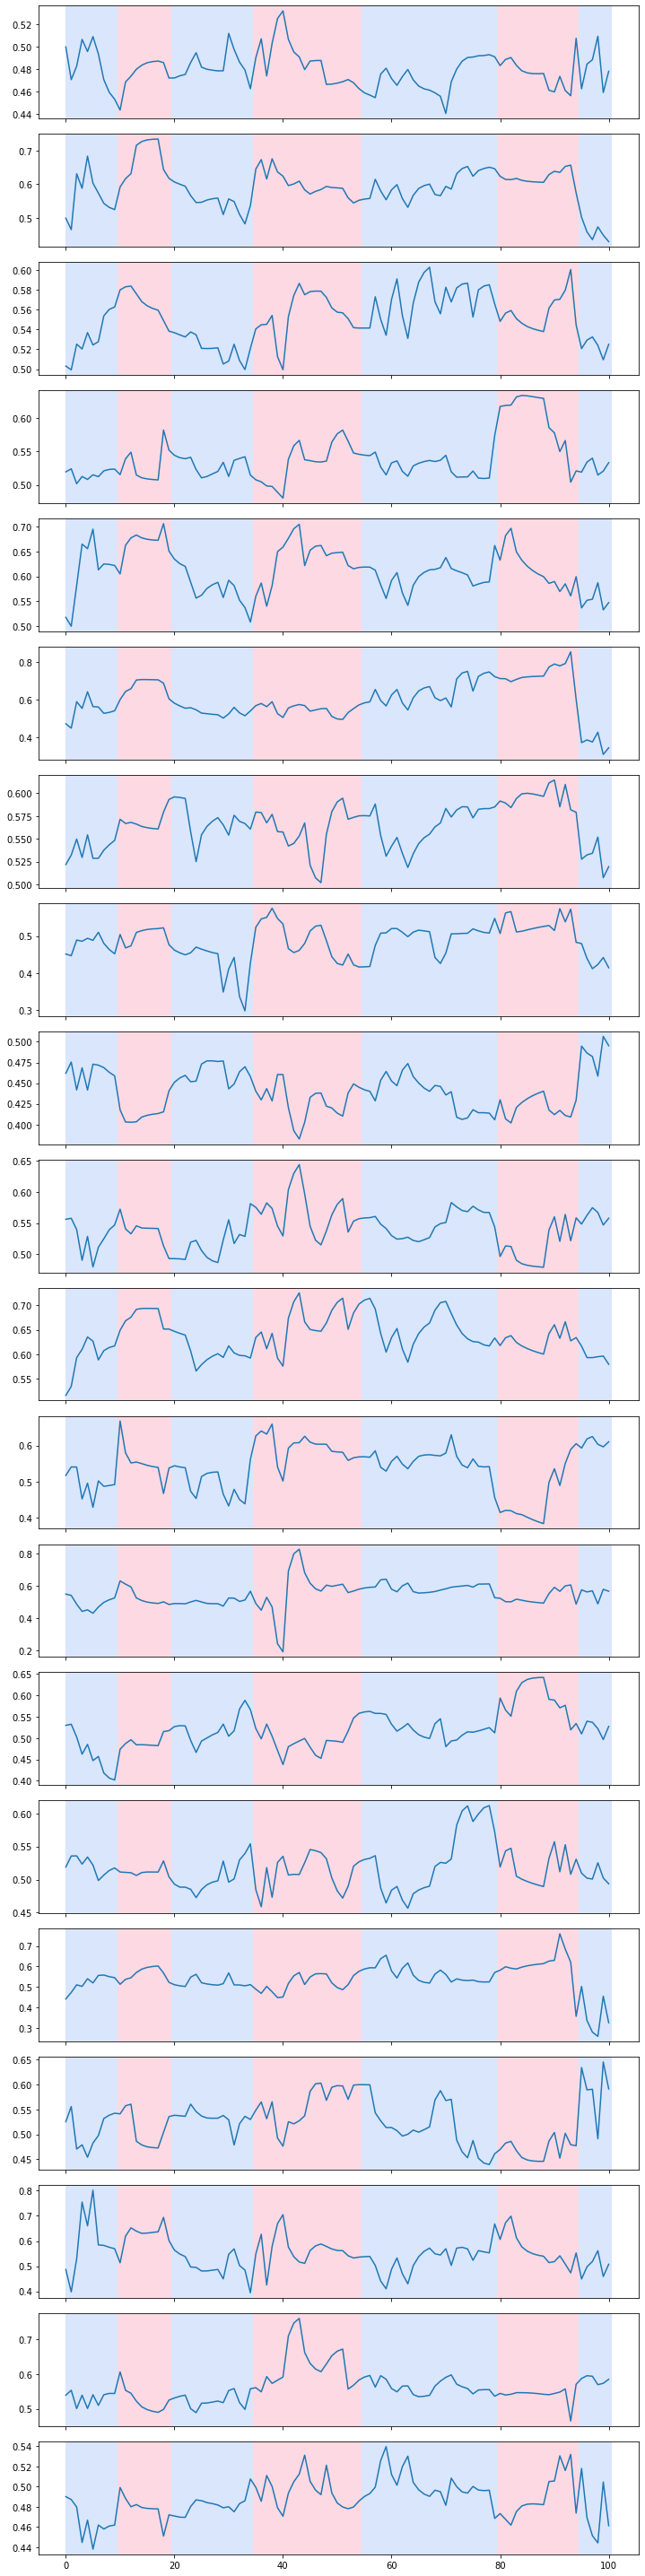

In [29]:
# "l1", "l2" "rbf", "linear", "normal", "ar"
algo = rpt.Window(width=10, model="rbf").fit(output_red)
my_bkps = algo.predict(n_bkps=15)

# show results
rpt.show.display(output_red, my_bkps) #, figsize=(10, 6))
plt.show()

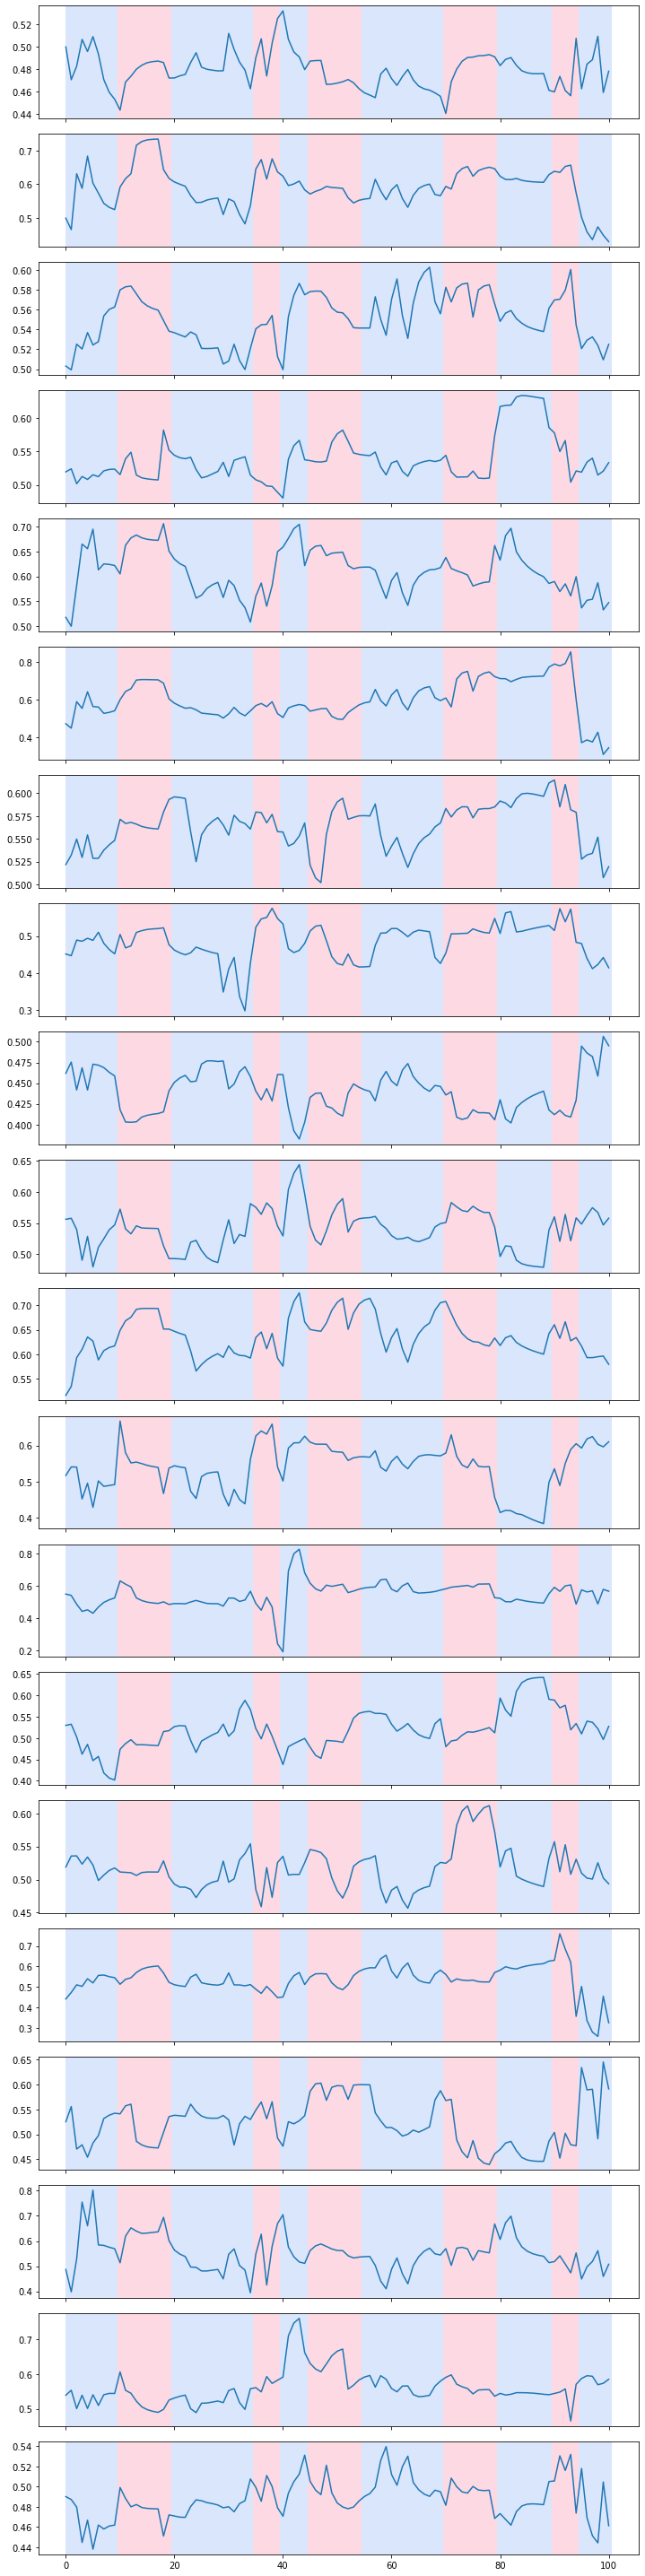

[10, 20, 35, 40, 45, 55, 70, 80, 90, 95, 101]


In [30]:
# "l1" "l2", "rbf"
algo = rpt.Dynp(model="rbf", min_size=3, jump=5).fit(output_red)
my_bkps = algo.predict(n_bkps=10)

# show results
rpt.show.display(output_red, my_bkps) #, figsize=(10, 6))
plt.show()
print(my_bkps)

In [31]:
len(result)

19

In [32]:
signal.shape

(1000, 3)

In [33]:
len(signal[1])

3

In [34]:
output_1.shape

torch.Size([101, 110])

In [35]:
#res = [[np.mean(i[i = i[j]]) for j in labels] for i in output_1.detach().numpy()]

In [36]:
def simplify(input_seq, answer_seq, output_seq,penalty) :
    # Step 1: Cluster the features using the differential
    differential = np.diff(output_seq.detach().numpy(), axis=0)
    agglo = FeatureAgglomeration(n_clusters=n_clusters)
    agglo.fit(differential)
    labels = agglo.labels_
    
    # Now we can reduce the input and the output of the model
    reduced_input = reduce_input(input_seq, labels)
    reduced_output = reduce_output(output_seq, labels = labels)
    
    # Step 2: Divide in subsequences
    algo = rpt.Pelt(model="rbf", jump=1,min_size=3).fit(output_red)
    bkps = algo.predict(pen=penalty)
    return reduced_input, reduced_output, bkps, labels
    
    
# IMPORTANT NOTE. The first interest subsequence is referred as 0 (not 1), to follow 
# Python coding conventions.
def conditional_feature_impact_subseq(model, input_seq, answer_seq, bkps, interest_subseq, method = "max", samples=50) :
    # FIRST STEP: Create input without the interest block(s)
    # Obtain the initial point of every interest subsequence.
    interest_subseq.sort()
    interest_points = [bkps[i] for i in interest_subseq]
    # Construct new list. First, check if the first subsequence is of interest
    input_alt = torch.empty(1, dtype = torch.int32)
    ini = 1
    print(interest_points)
    if bkps[0] == interest_points[0] :
        input_alt.append(input_seq[0])
    else :
        input_alt = input_alt + input_seq[list(range(0,bkps[0]))]
        #ini = interest_points[0]
        
    for i,bkp in enumerate(bkps[1:]) :
        if bkp not in interest_points :
            #input_alt = input_alt + input_seq[list(range(i,bkps[i+1]))]
            input_alt = torch.cat((input_alt,input_seq[list(range(bkps[i],bkps[i+1]))]),0)
    
    # SECOND STEP: Create an/many alternate answer sequences, depending on the "method" parameter, and then get an output
    #output = model(input_seq, answer_seq)
    answer_alt, likelihood = 0,0
    contrib = 0
    print(input_alt)
    if method == "max" :
        answer_alt, likelihood = generate_seq(model, input_alt, answer_seq, ini=ini+1, method = "max")
        output_alt = model(input_alt,answer_alt)
        contrib = (output_alt[-1]-output[-1]).detach().numpy()
    elif method == "ran" :
        res = []
        l_list = []
        for i in range(0,samples):
            answer_alt_tmp,likelihood_tmp = generate_seq(model, input_alt, answer_1, ini = ini+1, method = "ran")
            output_alt_tmp= model(input_alt, answer_alt_tmp)
            res.append(likelihood_tmp * output_alt_tmp[-1].detach().numpy())
            l_list.append(likelihood_tmp)
        output_alt = np.sum(res,axis=0)/np.sum(l_list)
        contrib = output_alt-output[-1].detach().numpy()
    return contrib
    
    
def feature_impact_range(model, input_seq, answer_seq, ini, end, method = "max", samples=50) :
    output = model(input_seq, answer_seq)
    input_alt = input_seq[list(range(0,ini))+list(range(end,len(input_seq)))]
    answer_alt, likelihood = 0,0
    if method == "max" :
        answer_alt, likelihood = generate_seq(model, input_alt, answer_seq, ini=ini+1, method = "max")
        output_alt = model(input_alt,answer_alt)
        return((output_alt[-1]-output[-1]).detach().numpy())
    elif method == "ran" :
        res = []
        l_list = []
        for i in range(0,samples):
            answer_alt_tmp,likelihood_tmp = generate_seq(model, input_alt, answer_1, ini = ini+1, method = "ran")
            output_alt_tmp= model(input_alt, answer_alt_tmp)
            res.append(likelihood_tmp * output_alt_tmp[-1].detach().numpy())
            l_list.append(likelihood_tmp)
        output_alt = np.sum(res,axis=0)/np.sum(l_list)
        return(output_alt-output[-1].detach().numpy())
    

In [37]:
conditional_feature_impact_subseq(model, input_1, answer_1,my_bkps,[4])

[45]
tensor([  9,   9,   1,   0,   1,   0,   3,   3,   3,   3,   4,   2,   2,   1,
          1,   1,   1,   1,  62,  23,  23,  23,  23,  23,  23,  23,  23,  23,
         23, 101, 102,  53, 101, 101,  53, 101, 101,  53, 101,  67,  55,  55,
         55,  28,  28,  28,  28,  54,  54,  54,  54,  54,  34,  27,  27,  27,
         27,  27,  27,  27,  27,  27,  27,  54,  54,   3,  46,  46,  46,  46,
         46,  46,  46,  46,  62,  60,  62,  62,  60,  60,  60,  60,  60,  60,
         61,  61,  94,  61,  63,  94,  63,  61,  61,  94,  63,  61],
       dtype=torch.int32)
tensor(1, dtype=torch.int32)
96
110
tensor(0, dtype=torch.int32)
96
110
tensor(1, dtype=torch.int32)
96
110
tensor(0, dtype=torch.int32)
96
110
tensor(3, dtype=torch.int32)
96
110
tensor(3, dtype=torch.int32)
96
110
tensor(3, dtype=torch.int32)
96
110
tensor(3, dtype=torch.int32)
96
110
tensor(4, dtype=torch.int32)
96
110
tensor(2, dtype=torch.int32)
96
110
tensor(2, dtype=torch.int32)
96
110
tensor(1, dtype=torch.int32)
96
110


D:\Enrique\Universidad\Repositories\KT-XAI\api.py:153: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  output = model(torch.tensor(input_seq[0:i+1]), torch.tensor(rec_answer_seq[0:i+1]))


tensor(27, dtype=torch.int32)
96
110
tensor(54, dtype=torch.int32)
96
110
tensor(54, dtype=torch.int32)
96
110
tensor(3, dtype=torch.int32)
96
110
tensor(46, dtype=torch.int32)
96
110
tensor(46, dtype=torch.int32)
96
110
tensor(46, dtype=torch.int32)
96
110
tensor(46, dtype=torch.int32)
96
110
tensor(46, dtype=torch.int32)
96
110
tensor(46, dtype=torch.int32)
96
110
tensor(46, dtype=torch.int32)
96
110
tensor(46, dtype=torch.int32)
96
110
tensor(62, dtype=torch.int32)
96
110
tensor(60, dtype=torch.int32)
96
110
tensor(62, dtype=torch.int32)
96
110
tensor(62, dtype=torch.int32)
96
110
tensor(60, dtype=torch.int32)
96
110
tensor(60, dtype=torch.int32)
96
110
tensor(60, dtype=torch.int32)
96
110
tensor(60, dtype=torch.int32)
96
110
tensor(60, dtype=torch.int32)
96
110
tensor(60, dtype=torch.int32)
96
110
tensor(61, dtype=torch.int32)
96
110
tensor(61, dtype=torch.int32)
96
110
tensor(94, dtype=torch.int32)
96
110
tensor(61, dtype=torch.int32)
96
110
tensor(63, dtype=torch.int32)
96
110
te

NameError: name 'output' is not defined

In [ ]:
input_1

In [ ]:
np.mean(feature_impact_range(model,input_1,answer_1,30,80, method = "ran",samples = 500))

In [ ]:
[0,1,2,3,4,5][0:0]

In [ ]:
input_1[list(range(0,3))+list(range(6,9))]

## Feature contribution

In [ ]:
lista = ["a","b","c","d","e"]

In [ ]:
dele = [2,3]

In [ ]:
lista_del = [i for i in lista]

In [ ]:
lista_del

In [ ]:
my_bkps

In [ ]:
output_1.shape

In [ ]:
lista+lista

In [ ]:
lista

In [ ]:
input_1[list(range(0,10))]

In [ ]:
lista[1:]